In [1]:
#!pip install lifetimes
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)
pd.set_option("display.float_format",lambda x: "%.4f" % x)

In [3]:
def outlier_tresholds(dataframe,variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range=quartile3-quartile1
    up_limit = quartile3+1.5*interquantile_range
    low_limit = quartile1-1.5*interquantile_range
    return low_limit,up_limit

In [4]:
def replace_with_tresholds(dataframe,variable):
    low_limit,up_limit = outlier_tresholds(dataframe,variable)
    dataframe.loc[(dataframe[variable]<low_limit),variable] = low_limit
    dataframe.loc[(dataframe[variable]>up_limit),variable] = up_limit

In [5]:
df = pd.read_csv('clv.csv', sep=';')

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
invoice,912705.0000,6066412.8825,573926.5515,4324290.0000,5844033.0000,6153673.0000,6489637.0000,6831513.0000
customer_id,912705.0000,801508.7404,493674.6577,60.0000,257884.0000,966963.0000,1272852.0000,1428447.0000
total_price,912705.0000,64.8771,49.4491,-73.0000,35.0000,50.0000,78.0000,3707.0000


In [7]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df.head()

,invoice,customer_id,invoice_date,total_price
0,4324290,1173745,2023-04-01,25.0000
1,4324291,84249,2023-04-01,37.0000
2,4324292,146813,2023-04-01,37.0000
3,4324293,146813,2023-04-01,37.0000
4,4324295,1257162,2023-04-01,39.5000


In [8]:
df.isnull().sum()
df.dropna(inplace=True)

In [9]:
#Suppressing outliers

replace_with_tresholds(df,"total_price")

In [10]:
df["totalprice"]=df["total_price"]

In [11]:
#Using the maximum date as today's date and setting date for analysis

today_date= df['invoice_date'].max()

In [26]:
#Preparation of Lifetime Data Structure 

#P.S Everything we do we will assume customers bought weekly

cltv_df = df.groupby('customer_id').agg({
    "invoice_date": [lambda invoice_date:(invoice_date.max()-invoice_date.min()).days,lambda date:(today_date-date.min()).days],
    'invoice': lambda num: num.nunique(),
    "totalprice": lambda totalprice: totalprice.sum()})

In [27]:
#Renaming the columns to match the RMF Analysis

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ["recency","T","frequency","monetary"]

In [14]:
#We need people who bought atleast twice

cltv_df=cltv_df[(cltv_df["frequency"]>1)]
cltv_df=cltv_df[(cltv_df["monetary"]>1)]

In [15]:
#calculate the average earnings per transaction

cltv_df["monetary"] = cltv_df["monetary"]/cltv_df["frequency"]

In [16]:
#expressing the recency value in weekly terms

cltv_df["recency"]=cltv_df["recency"]/7

In [17]:
#calculating how many weeks the customer has been our customer

cltv_df["T"]=cltv_df["T"]/7

In [18]:
#Modelling part(Buy till you die), BG/NBD ( Beta Geometric / Negative Binomial Distribution) model

bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df["frequency"],cltv_df["recency"],cltv_df["T"])

<lifetimes.BetaGeoFitter: fitted with 140809 subjects, a: 0.78, alpha: 3.41, b: 4.09, r: 1.78>

In [20]:
#Predictions for multiple periods

cltv_df['estiamted_purchase_1_week'] = bgf.predict(1,cltv_df["frequency"],cltv_df["recency"],cltv_df["T"])
cltv_df['estiamted_purchase_1_month'] = bgf.predict(4,cltv_df["frequency"],cltv_df["recency"],cltv_df["T"])
cltv_df['estiamted_purchase_3_month'] = bgf.predict(12,cltv_df["frequency"],cltv_df["recency"],cltv_df["T"])

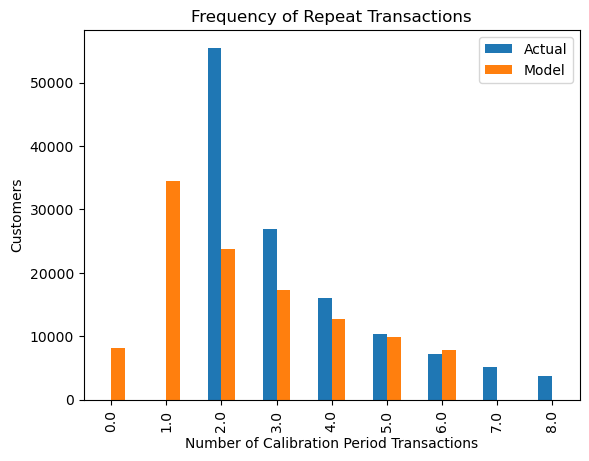

In [21]:
#Evaluation of the Predicted Outcomes

plot_period_transactions(bgf)
plt.show()

In [22]:
#Using the Gamma-Gamma Model to predict the average profit

ggf=GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df["frequency"],cltv_df["monetary"])

ggf.conditional_expected_average_profit(cltv_df["frequency"],cltv_df["monetary"]).head()

ggf.conditional_expected_average_profit(cltv_df["frequency"],cltv_df["monetary"]).sort_values(ascending=False).head()

cltv_df["expected_average_profit"]=ggf.conditional_expected_average_profit(cltv_df["frequency"],cltv_df["monetary"])

cltv_df.sort_values("expected_average_profit",ascending=False)

,recency,T,frequency,monetary,estiamted_purchase_1_week,estiamted_purchase_1_month,estiamted_purchase_3_month,expected_average_profit
customer_id,,,,,,,,
869043,0.0000,19.1429,2,557.5000,0.0008,0.0033,0.0091,579.0142
1290292,8.8571,21.0000,2,557.5000,0.0500,0.1938,0.5396,579.0142
1331536,0.1429,15.5714,2,548.7500,0.0022,0.0086,0.0236,569.9606
1376069,2.0000,8.2857,2,530.7500,0.0826,0.3107,0.8151,551.3362
227430,8.0000,23.7143,3,521.0000,0.0193,0.0749,0.2092,534.3444
...,...,...,...,...,...,...,...,...
932870,16.7143,17.1429,6,6.0000,0.3388,1.2988,3.5320,6.7763
113880,9.8571,25.1429,9,6.1111,0.0015,0.0058,0.0160,6.6276
161467,18.7143,24.2857,4,5.2500,0.1473,0.5715,1.5937,6.4083


In [24]:
#Calculation of CLTV with BG/NBD and Gamma Gamma Model


cltv=ggf.customer_lifetime_value(bgf,
                                 cltv_df["frequency"],
                                 cltv_df["recency"],
                                 cltv_df["T"],
                                 cltv_df["monetary"],
                                 time=3 ,   
                                 freq="W", 
                                 discount_rate=0.01)
cltv.head()
cltv=cltv.reset_index()

cltv_final=cltv_df.merge(cltv,on="customer_id",how="left")

cltv_final.sort_values(by="clv",ascending=False).head(10)

,customer_id,recency,T,frequency,monetary,estiamted_purchase_1_week,estiamted_purchase_1_month,estiamted_purchase_3_month,expected_average_profit,clv
75124,961107,25.2857,25.5714,210,123.1524,7.0041,26.9885,74.1541,123.2117,9635.4897
100154,1206243,25.1429,25.4286,192,115.4375,6.4547,24.8678,68.3070,115.4997,8319.9359
85303,1066920,26.0000,26.0000,181,108.8149,6.1097,23.5555,64.7978,108.8785,7441.1504
88252,1101529,25.8571,26.0000,148,133.5541,4.9748,19.1817,52.7754,133.6430,7439.1500
12900,109674,25.1429,25.4286,153,115.9542,5.1769,19.9468,54.8005,116.0326,6705.7382
18521,145060,26.0000,26.0000,154,113.3636,5.2036,20.0633,55.1989,113.4403,6604.5237
27747,207254,26.0000,26.0000,168,102.9911,5.6734,21.8741,60.1761,103.0572,6540.9801
97204,1183724,26.0000,26.0000,167,102.3772,5.6399,21.7447,59.8206,102.4435,6463.6202
33840,242734,26.0000,26.0000,165,102.4606,5.5728,21.4860,59.1095,102.5277,6392.0492
98146,1191516,25.7143,25.7143,162,99.5895,5.5251,21.2951,58.5439,99.6567,6153.1715


In [25]:
cltv_final["segment"]=pd.qcut(cltv_final["clv"],4,labels=["D","C","B","A"])

cltv_final.groupby("segment").agg({"count","mean","sum"})

customer_id                          recency                          T                     frequency                monetary                      estiamted_purchase_1_week                   estiamted_purchase_1_month                   estiamted_purchase_3_month                    expected_average_profit                         clv                       
              count          sum        mean   count         sum    mean  count         sum    mean     count     sum   mean    count          sum    mean                     count        sum   mean                      count        sum   mean                      count         sum   mean                   count          sum    mean  count           sum     mean
segment                                                                                                                                                                                                                                                                                                                                                                     
D             35203  29284011856 831861.2577   35203 115720.4286  3.2872  35203 697550.7143 19.8151     35203  116875 3.3200    35203 2065278.5847 58.6677                     35203   310.5239 0.0088                      35203  1194.4739 0.0339                      35203   3276.3262 0.0931                   35203 2185225.2335 62.0750  35203   178913.2381   5.0823
C             35203  27583503403 783555.4755   35203 370635.5714 10.5285  35203 665242.2857 18.8973     35203  114217 3.2445    35203 1998214.2675 56.7626                     35203  3095.4882 0.0879                      35203 11892.7468 0.3378                      35203  32561.4598 0.9250                   35203 2109357.3333 59.9198  35203  1671450.5431  47.4803
B             35201  26096737584 741363.5290   35201 506001.1429 14.3746  35201 638888.7143 18.1497     35201  147352 4.1860    35201 2201710.3836 62.5468                     35201  6836.5773 0.1942                      35201 26139.0667 0.7426                      35201  70941.7799 2.0153                   35201 2300038.7113 65.3402  35201  4220441.1019 119.8955
A             35202  25319972622 719276.5360   35202 538697.2857 15.3030  35202 600217.4286 17.0507     35202  318058 9.0352    35202 3017403.1989 85.7168                     35202 15608.0420 0.4434                      35202 59083.6610 1.6784                      35202 157870.9719 4.4847                   35202 3101626.4592 88.1094  35202 12508263.2275 355.3282

Using Pycaret

In [28]:
pip install pycaret

     -------------------------------------- 483.9/483.9 kB 3.0 MB/s eta 0:00:00
     -------------------------------------- 106.8/106.8 kB 6.0 MB/s eta 0:00:00
     -------------------------------------- 65.9/65.9 MB 930.0 kB/s eta 0:00:00
     ---------------------------------------- 81.8/81.8 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 73.4/73.4 kB 1.3 MB/s eta 0:00:00
     -------------------------------------- 153.4/153.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 44.0/44.0 kB 2.3 MB/s eta 0:00:00
     -------------------------------------- 302.2/302.2 kB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 17.1/17.1 MB 1.0 MB/s eta 0:00:00
     -------------------------------------- 282.6/282.6 kB 1.3 MB/s eta 0:00:00
     ---------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
